In [1]:
import numpy as np
import math
from math import sqrt as sqrt
import itertools as it
from qiskit import *
from qiskit.providers import aer
from qiskit import Aer
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

import qiskit.tools.jupyter

In [2]:
traces = [2.00000000000000, 1.00000000000000*sqrt(2), -1.00000000000000,
       -1.00000000000000*sqrt(2), -1.00000000000000, 0, 0, 0,
       0.000000000000000, 0, -1.00000000000000, -1.00000000000000*sqrt(2),
       1.00000000000000, 1.00000000000000*sqrt(2), 0, 0, 0, 0,
       -1.00000000000000, 0, 1.00000000000000, 0, 0, 0, 0,
       1.00000000000000*sqrt(2), 1.00000000000000, 0, -1.00000000000000,
       -1.00000000000000*sqrt(2), 0, 0, -2.00000000000000,
       -1.00000000000000*sqrt(2), 1.00000000000000,
       1.00000000000000*sqrt(2), 1.00000000000000, 0, 0, 0,
       0.000000000000000, 0, 1.00000000000000, 1.00000000000000*sqrt(2),
       -1.00000000000000, -1.00000000000000*sqrt(2), 0, 0, 0, 0,
       1.00000000000000, 0, -1.00000000000000, 0, 0, 0, 0,
       -1.00000000000000*sqrt(2), -1.00000000000000, 0, 1.00000000000000,
       1.00000000000000*sqrt(2), 0, 0]

trace_mag = np.linalg.norm(traces)

trace_ham = np.diag(traces)

In [3]:
zbase_trace = SparsePauliOp.from_operator(trace_ham)
zbase_trace_operator = zbase_trace.to_operator()

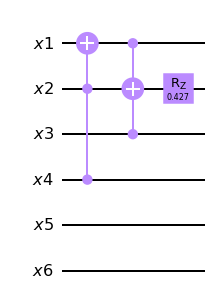

In [6]:
x1 = QuantumRegister(1,"x1")
x2 = QuantumRegister(1,"x2")
x3 = QuantumRegister(1,"x3")
x4 = QuantumRegister(1,"x4")
x5 = QuantumRegister(1,"x5")
x6 = QuantumRegister(1,"x6")

a = 1/8 * (math.sqrt(2) + 1)
b = 1/8 * (math.sqrt(2) - 1)
d = 1/8
e = math.sqrt(2)/8
f = 1/4 * (1 + math.sqrt(2)/2)
g = 1/4 * (1 - math.sqrt(2)/2)

traceGate = QuantumCircuit(x1,x2,x3,x4,x5,x6, name=" [$trace$ Gate] ")

# traceGate.cx(x2,x5)
# traceGate.ccx(x1,x4,x5)
# traceGate.ccx(x1,x2,x5)
# traceGate.mcx([x1,x2,x3,x4],x5)
# traceGate.rz(a,x5)
traceGate.mcx([x2,x4],x1) # x1+x2+x4
traceGate.mcx([x1,x3],x2) # x1+x2+x4+x3+x2 = x1+x2+x4+x3
traceGate.rz(f,x2) # eventually x3
#traceGate.mcx([x1])

#traceGate.append(zbase_trace_operator,[x1,x2,x3,x4,x5,x6])
traceGate.draw("mpl")

In [8]:
zbase_trace

SparsePauliOp(['ZIIIZI', 'ZIIIZZ', 'ZIIZZI', 'ZIIZZZ', 'ZIZIZI', 'ZIZIZZ', 'ZIZZZI', 'ZIZZZZ', 'ZZIIZI', 'ZZIIZZ', 'ZZIZII', 'ZZIZIZ', 'ZZIZZI', 'ZZIZZZ', 'ZZZIZI', 'ZZZIZZ', 'ZZZZII', 'ZZZZIZ', 'ZZZZZI', 'ZZZZZZ'],
              coeffs=[ 0.3017767+0.j, -0.0517767+0.j,  0.3017767+0.j, -0.0517767+0.j,
  0.125    +0.j,  0.125    +0.j,  0.125    +0.j,  0.125    +0.j,
  0.3017767+0.j, -0.0517767+0.j, -0.1767767+0.j,  0.1767767+0.j,
  0.125    +0.j,  0.125    +0.j, -0.125    +0.j, -0.125    +0.j,
  0.4267767+0.j,  0.0732233+0.j,  0.3017767+0.j, -0.0517767+0.j])

In [ ]:
sum(zbase_trace.coeffs)

In [ ]:
trace_ham